96 48
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-20 12:29:13.206958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-20 12:29:13.207079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-04-20 12:29:13.454261: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-20 12:29:14.064681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 12:29:14.182617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 12:29:14.257344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 - 1s - loss: 0.0431 - 1s/epoch - 16ms/step
Epoch 2/100
94/94 - 1s - loss: 0.0229 - 600ms/epoch - 6ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0163 - 474ms/epoch - 5ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0148 - 469ms/epoch - 5ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0140 - 474ms/epoch - 5ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0130 - 465ms/epoch - 5ms/step
Epoch 7/100
94/94 - 1s - loss: 0.0121 - 511ms/epoch - 5ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0112 - 494ms/epoch - 5ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0104 - 498ms/epoch - 5ms/step
Epoch 10/100
94/94 - 1s - loss: 0.0094 - 527ms/epoch - 6ms/step
Epoch 11/100
94/94 - 1s - loss: 0.0084 - 535ms/epoch - 6ms/step
Epoch 12/100
94/94 - 1s - loss: 0.0074 - 533ms/epoch - 6ms/step
Epoch 13/100
94/94 - 1s - loss: 0.0066 - 525ms/epoch - 6ms/step
Epoch 14/100
94/94 - 1s - loss: 0.0057 - 560ms/epoch - 6ms/step
Epoch 15/100
94/94 - 1s - loss: 0.0050 - 503ms/epoch - 5ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0043 - 489ms/epoch - 5ms/step

2023-04-20 12:30:06.185601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 12:30:06.239131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Train Score: 22.68 RMSE
Test Score: 49.34 RMSE


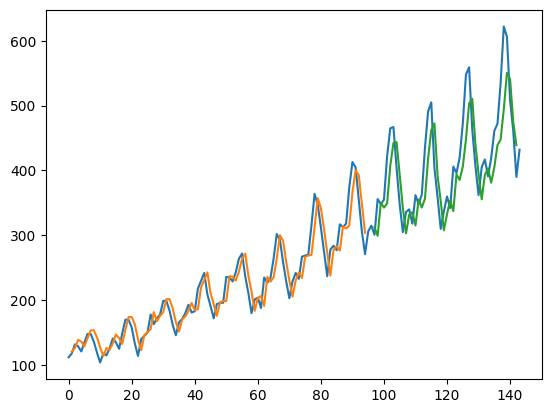

In [1]:
# The problem you will look at in this post is the 
# International Airline Passengers prediction problem.

# This is a problem where, given a year and a month, 
# the task is to predict the number of international airline 
# passengers in units of 1,000. The data ranges from January 
# 1949 to December 1960, or 12 years, with 144 observations.

# read csv documentation
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# import pandas
# import matplotlib.pyplot as plt
# dataset = pandas.read_csv('airline.csv', 
#                           usecols=[1], engine='python') # USECOLS skips the first row
# plt.plot(dataset)
# plt.show()


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
tf.random.set_seed(7)

# load the dataset
dataframe = pd.read_csv('airline.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset to the range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)


# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)



# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()